In [1]:
import seaborn as sns

from scipy.stats import kurtosis, skew

from rcv_distribution import *
from MDS_analysis import *
from voting_rules import *

Fist we run MDS to see the ordering of the candidates

c:\Users\mahsh\Documents\GitHub\bugs-in-democracy\cleaned files\MDS_analysis.py:162: RuntimeWarning: divide by zero encountered in true_divide
  distance = 1 / np.sqrt(freq_upper_triangle)


Normalized distances: {'Golden, Jared F.': 0.0, 'St. Clair, Lucas R.': 0.6337181829233953, 'Olson, Craig R.': 1.7356960462320883, 'Fulford, Jonathan S.': 3.0}


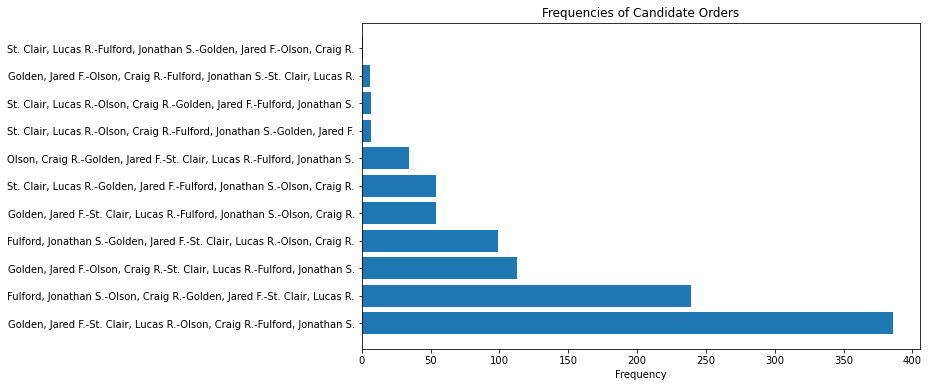

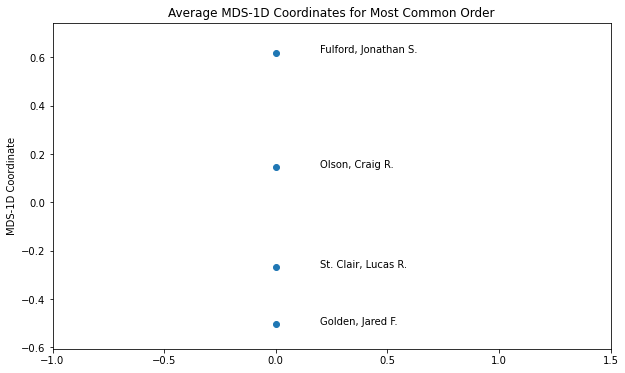

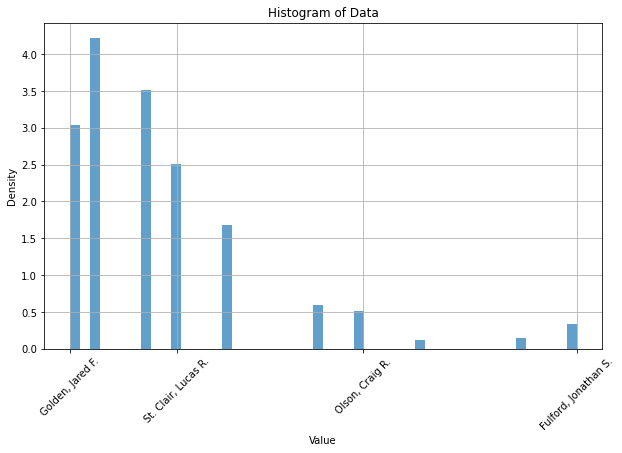

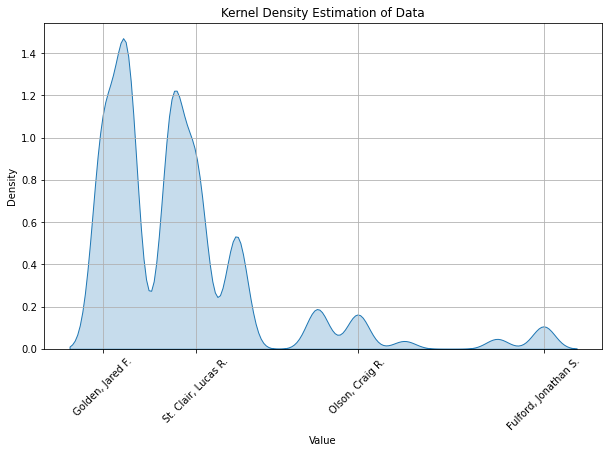

In [2]:
# Test the function with a custom CSV file
csv = "dataverse_files/Maine_06122018_DemocraticPrimaryforCD2.csv"

ballots, candidates = parse_election_data(csv)

# Perform the RCV analysis
test = perform_rcv_analysis(ballots, candidates, n_runs=1000, metric=False)
mds_1d_coordinates, mds_2d_coordinates, most_common_order, order_frequencies, candidate_names = test

# Print the normalized distances between candidates and plot the MDS analysis
normalized_distances = get_distances_normalized(most_common_order, mds_1d_coordinates, candidate_names)
print("Normalized distances:", normalized_distances)
plot_rcv_analysis(mds_1d_coordinates, mds_2d_coordinates, most_common_order, order_frequencies, candidate_names)

# Get the consistency points for the bimodality analysis
points = get_consistency_points(ballots, candidates, normalized_distances)

# Create a list of data points
data_points = []
for key, value in points.items():
    data_points.extend([key] * value)

# Convert to numpy array
data_points = np.array(data_points)

# Prepare data for histogram
data_list = [x for x, count in points.items() for _ in range(count)]

normalized_points = []
normalized_names = []
for name in normalized_distances:
    normalized_names.append(name)
    normalized_points.append(normalized_distances[name])

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(data_list, bins=50, density=True, alpha=0.7)
plt.title('Histogram of Data')
plt.xticks(normalized_points, normalized_names, rotation=45)
plt.xlabel('Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()

# Plot kernal density estimation
plt.figure(figsize=(10, 6))
sns.kdeplot(data_list, fill=True)
plt.title('Kernel Density Estimation of Data')
plt.xticks(normalized_points, normalized_names, rotation=45)
plt.xlabel('Value')
plt.ylabel('Density')
plt.grid(True)
plt.show()


In [9]:
print("gamma is: ", get_permissive_gamma(ballots, normalized_distances)[1])

gamma is:  0.7590890050047402


Run this cell to see all the consistent and inconsistent ballots 

In [3]:
print("normalized distances: ", normalized_distances)
consistent_ballots = get_permissive_gamma(ballots, normalized_distances)[0]
print("consistent ballots: ")
for b in consistent_ballots:
    print(b, ": ", consistent_ballots[b])
print("inconsistent ballots: ")
inconsiste_ballots = {}
total = 0
for b in ballots:
    if len(b) > 0:
        total += ballots[b]
    if b not in consistent_ballots:
        inconsiste_ballots[b] = ballots[b]
        print(b, ": ", ballots[b])
print(total)

normalized distances:  {'Golden, Jared F.': 0.0, 'St. Clair, Lucas R.': 0.6337181829233953, 'Olson, Craig R.': 1.7356960462320883, 'Fulford, Jonathan S.': 3.0}
consistent ballots: 
('Golden, Jared F.',) :  5719
('Olson, Craig R.',) :  965
('St. Clair, Lucas R.',) :  4733
('Golden, Jared F.', 'St. Clair, Lucas R.', 'Olson, Craig R.') :  2048
('St. Clair, Lucas R.', 'Golden, Jared F.', 'Fulford, Jonathan S.') :  284
('Golden, Jared F.', 'St. Clair, Lucas R.') :  3595
('St. Clair, Lucas R.', 'Golden, Jared F.', 'Olson, Craig R.', 'Fulford, Jonathan S.') :  2118
('Golden, Jared F.', 'St. Clair, Lucas R.', 'Olson, Craig R.', 'Fulford, Jonathan S.') :  2307
('Golden, Jared F.', 'Fulford, Jonathan S.') :  205
('St. Clair, Lucas R.', 'Golden, Jared F.') :  2835
('Golden, Jared F.', 'St. Clair, Lucas R.', 'Fulford, Jonathan S.') :  350
('Olson, Craig R.', 'St. Clair, Lucas R.', 'Golden, Jared F.') :  357
('Golden, Jared F.', 'Olson, Craig R.') :  762
('Fulford, Jonathan S.', 'Olson, Craig R.', 

assign the two candidates you want to examin to candidate1 and candidiate 2

In [5]:
candidate1 = 'Golden, Jared F.'
candidate2 = 'St. Clair, Lucas R.'

In [10]:
c1 = 0
c2 = 0
total = 0
for b in ballots:
    if (len(b) > 0):
        total += ballots[b]
        if candidate1 in b or candidate2 in b:
            if candidate2 not in b and candidate1 in b:
                c1 += ballots[b]
                continue
            if candidate1 not in b and candidate2 in b:
                c2 += ballots[b]
                continue
            if b.index(candidate2) < b.index(candidate1):
                c2 += ballots[b]
            else:
                c1 += ballots[b]
print("the whole election: ")
print("total: ", total)
print(candidate1, ": ", c1)
print(candidate2, ": ", c2)


the whole election: 
total:  45357
Golden, Jared F. :  23673
St. Clair, Lucas R. :  19934


now just look at the consistent ballots

In [11]:
c1 = 0
c2 = 0
total = 0
for b in consistent_ballots:
    if (len(b) > 0):
        total += ballots[b]
        if candidate1 in b or candidate2 in b:
            if candidate2 not in b and candidate1 in b:
                c1 += ballots[b]
                continue
            if candidate1 not in b and candidate2 in b:
                c2 += ballots[b]
                continue
            if b.index(candidate2) < b.index(candidate1):
                c2 += ballots[b]
            else:
                c1 += ballots[b]
print("the whole election: ")
print("total: ", total)
print(candidate1, ": ", c1)
print(candidate2, ": ", c2)


the whole election: 
total:  34430
Golden, Jared F. :  15666
St. Clair, Lucas R. :  17014
